Imports

In [181]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

Load the raw data and move it to the raw folder

In [182]:
all_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")
pd.set_option("display.max_columns", None)

#Transfer raw data to the raw folder
all_data.to_csv("../data/raw/all_data.csv")
all_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Exploration and data cleaning

In [183]:
#Obtain the dimensions of the dataset
all_data.shape

# Obtain the information about data types and null values
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Check for constant values, we don't have any constant values so no need to delete them.

In [184]:
all_data.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

Search for duplicates (in this case will be any house or room listed twice or more), and if there are any, delete them.

In [185]:
all_data.duplicated().sum()

np.int64(0)

After checking for duplicates we need to remove redundant information. In this case will be the following:
- id: this data is not relevant for further analysis as every id is unique and it will not provide any useful information. (We may use it depending on the further analysis)
- name: name of the room or the apartment/house is not really useful as we have other variables that will provide more information, also some of them may be null.
- host_name: this variable can be deleted as we have host_id, which provides information about the host and is unique to each of them, also some of them may be null.


In [186]:
#Removing redundant variables
all_data.drop(["id", "name", "host_name"], axis= 1, inplace= True)

Now that duplicates and redundant information is removed or checked, we need to know if some data is null or missing.


<Axes: >

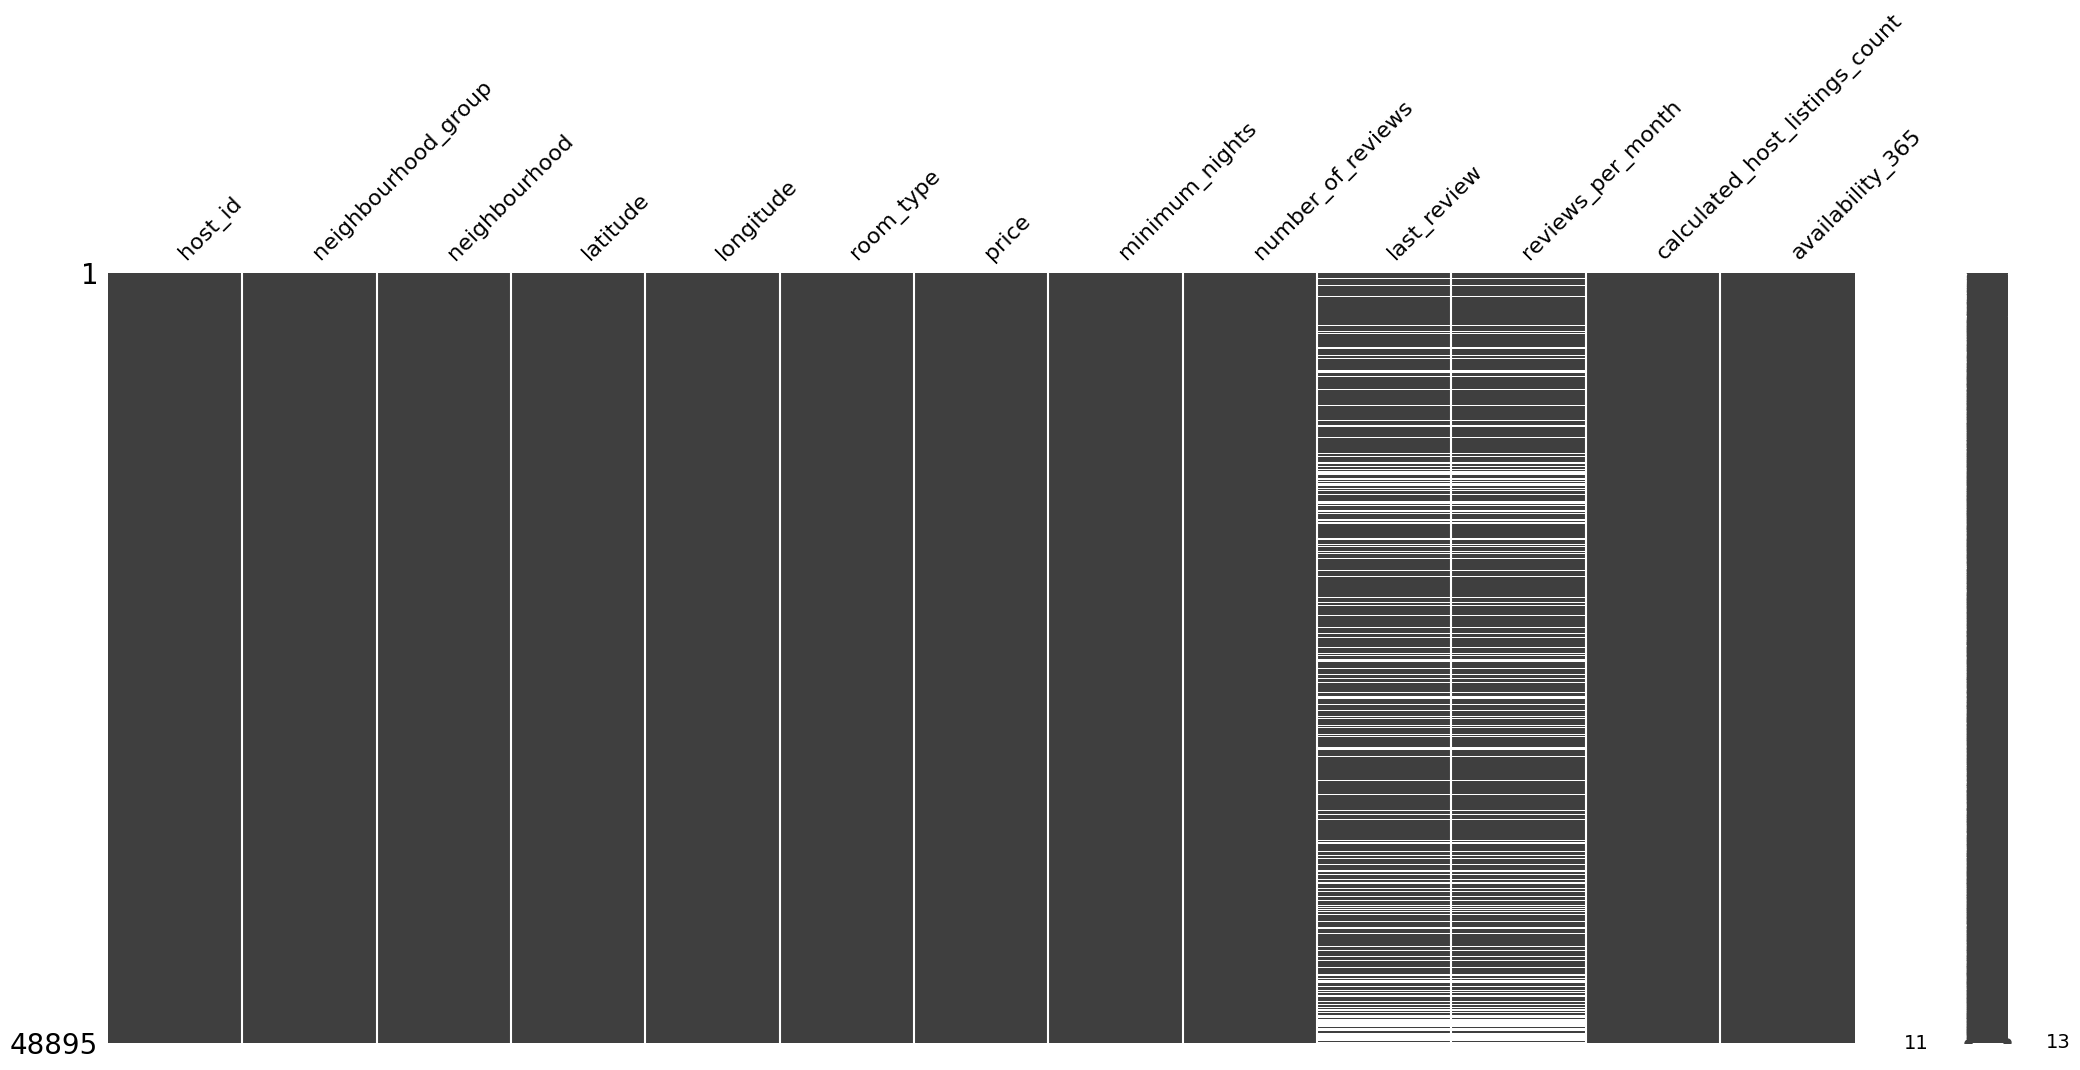

In [187]:
all_data.isnull().mean()*100

#Using missingno library we can see if there is any pattern if we have missing values
msno.matrix(all_data)

Having this information we conclude that last_review and reviews_per_month variables have at least 20% of it's data missing or null. We have two ways of dealing with null data:
- Using KNN algorithm to fill the gaps.
- Deleting the variables that have missing values.

Using msno we observe that when number of reviews is 0, there aren't any last reviews or reviews per month as expected, so it makes no sense to fill them if there are no reviews.

In [188]:
#Deleting last_reviews and reviews_per_month
all_data.drop(["last_review", "reviews_per_month"], axis= 1, inplace= True)

#Resulting dataframe after the analysis
all_data.head()



,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


Because we want to predict the price of each airbnb we are going to analyse that variable.

In [189]:
all_data["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

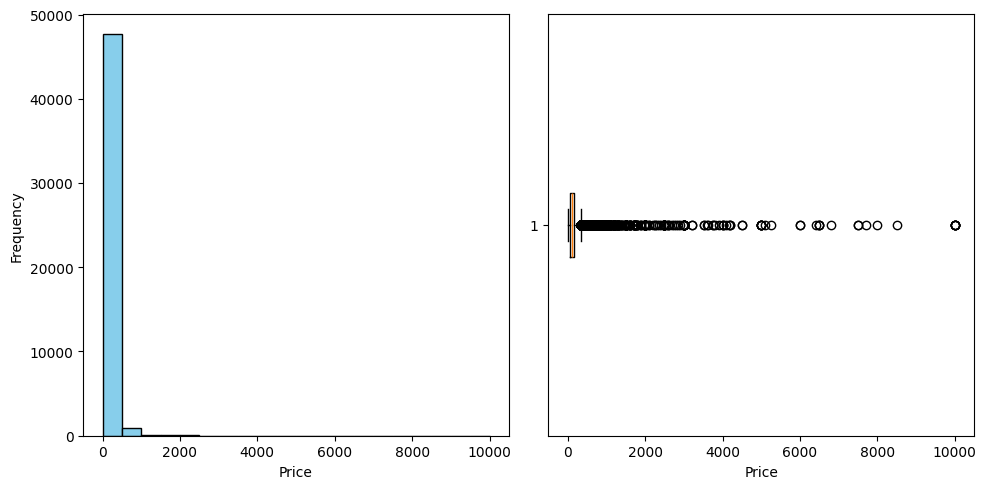

In [190]:
#Creating two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Creating a histogram
ax[0].hist(all_data['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

# Creating a boxplot
ax[1].boxplot(all_data['price'], vert=False)
ax[1].set_xlabel('Price')

# Show the plots
plt.tight_layout()
plt.show()

Based on these results, it will be optimal if we convert the price variable to a logaritmical scale, since most of the prices are at the left and a few at right (highest prices).

With this method we will achieve that price variable will have a normal distribution. And we will also delete all the houses/rooms listed with the price at 0, which is incorrect.

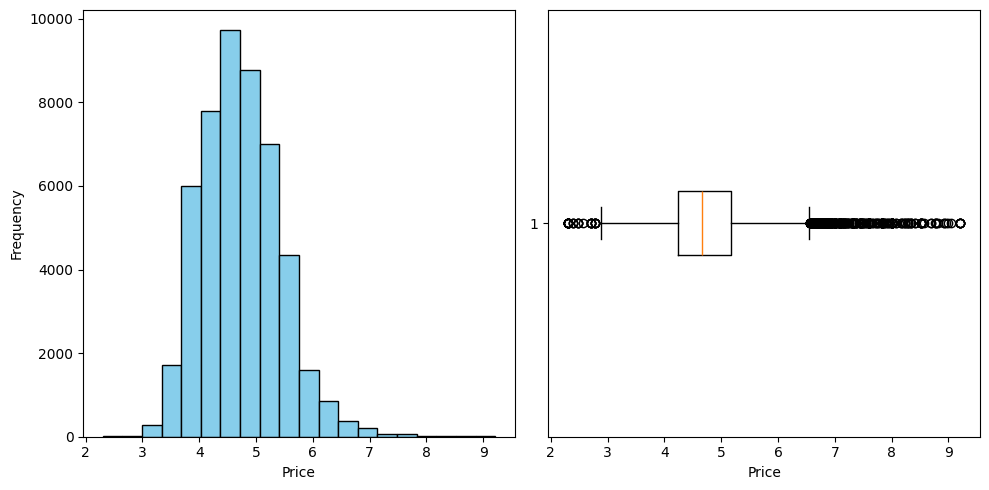

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,5.003946
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,5.416100
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,5.010635
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,4.488636
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4.382027


In [191]:
#Before creating the log price we need to delete all the listed houses/rooms with price at 0
all_data = all_data[all_data["price"] > 0]

#Using numpy to create a new column, which is going to have a logaritmic scaled price
all_data["log_price"] = np.log(all_data["price"])

#Creating two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Creating a histogram
ax[0].hist(all_data['log_price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')

#Creating a boxplot
ax[1].boxplot(all_data['log_price'], vert=False)
ax[1].set_xlabel('Price')

#Show the plots
plt.tight_layout()
plt.show()

all_data.head()

Now prices are much more suitable.

After this analysis we need to identify the influential observations using the cook's distance. Using statsmodel

Since we are working with categorical variables as well we need to convert them to numerical before continue

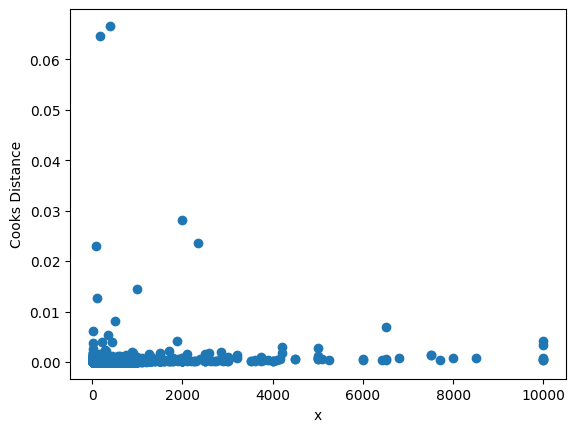

In [192]:
#In order to not have any problems with indexes further on, we need to order them again
all_data = all_data.reset_index(drop=True)

#Factorize categorical variables
all_data["room_type"] = pd.factorize(all_data["room_type"])[0]
all_data["neighbourhood_group"] = pd.factorize(all_data["neighbourhood_group"])[0]
all_data["neighbourhood"] = pd.factorize(all_data["neighbourhood"])[0]

#Dividing variables into dependant and independant values using the price variable (the one that we will predict)
X = all_data.drop(["price", "log_price"], axis= 1) #Independant variables
y = all_data["log_price"]# Dependant variables, target

#Adjust a linear regression model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

#Getting the cook's distance
cooks_distance = model.get_influence().cooks_distance

plt.scatter(all_data.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

Know that we know multiple cases that the cook distance may be bigger, we need to create a cutting edge (based on a consensus) to discard those listings that differ the most

In [193]:
cutting = 4/len(all_data)

#This is how we calculate how many listings need to be deleted
len(np.where(cooks_distance[0]> cutting)[0])
all_data.shape

(48884, 12)

We need to delete 2879 listings, these are influential observations.

In [194]:
all_data = all_data.drop(np.where(cooks_distance[0]>cutting)[0])
all_data.shape


(46005, 12)

After these processes we need to separate (again, just in case) the dependant variables from the dependant ones. After that, we split them into train and test.

In [195]:
X = all_data.drop(["price", "log_price"], axis= 1) #Independant variables
y = all_data["log_price"]# Dependant variables, target

#Now using train_test_split from sklearn, we separate the variables. Ones are going to be used for training the algorithm and the others to test the algorithm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42) #Random state controls how many shuffles is applied to the data before spliting. It's the same number to replicate the same experiment


Now that the variables are separated, we need to select the characteristics to use in the model. There are other methods, I will not use SelectKBest this time as we don't know what to choose yet.

In [196]:
#Now using Xgboost we get the importance of each variable (characteristic). We neeed to use XGBRegresor as we trying to predict a continous variable
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state= 42).fit(X_train, y_train)

#Create a dataframe with every variable name and it's importance, multiplyed by 100 to make it a percentage
characteristics_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})

#Sort the values
characteristics_imp = characteristics_imp.sort_values(by='Importance', ascending=False)

characteristics_imp

,Feature,Importance
5,room_type,89.199898
4,longitude,2.988129
3,latitude,1.786856
6,minimum_nights,1.297013
9,availability_365,1.160894
2,neighbourhood,0.910003
8,calculated_host_listings_count,0.809230
7,number_of_reviews,0.787759
1,neighbourhood_group,0.561919
0,host_id,0.498292


Variables that have more than 1% of importance are the ones that will be choosen. These will be the new X_train and X_test

In [197]:
X_train = X_train[characteristics_imp[characteristics_imp.Importance>1]['Feature'].values]
X_test = X_test[characteristics_imp[characteristics_imp.Importance>1]['Feature'].values]

Now, we calculate the VIF, to calculate which variables are most correlated to each of them


In [198]:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

room_type           1.230036
longitude           1.302974
latitude            1.030446
minimum_nights      1.254102
availability_365    1.227793
dtype: float64

Looking at the results, we observe that none of the variables selected are correlated, so we are going to keep them. In case two of them have a bigger correlation, we can multiply them and get a new one but deleting the two others

To finish this exercise, we need to scale the variables. Since some algorithms require to have them scaled

In [199]:
#No binary variables at this point
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns

X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

#Create the scaler object, using X_train_num to fit the scaler
scaler = MinMaxScaler().fit(X_train_num)

#Transform numeric variables with the scaler
X_ẗrain_num_sc = scaler.transform(X_train_num)
X_ẗest_num_sc = scaler.transform(X_test_num)

#Move the scale data into a dataframe
X_train_sc = pd.concat([pd.DataFrame(X_ẗrain_num_sc, columns = X_train_num.columns), X_train[binary_cols].reset_index(drop=True)], axis=1)
X_test_sc = pd.concat([pd.DataFrame(X_ẗest_num_sc, columns = X_test_num.columns), X_test[binary_cols].reset_index(drop=True)], axis=1)

X_train


,room_type,longitude,latitude,minimum_nights,availability_365
34042,0,-73.96292,40.71185,2,365
16334,1,-73.96603,40.57509,1,0
22215,0,-73.89635,40.73443,1,309
6821,1,-73.98630,40.76332,2,0
32611,0,-73.97598,40.72520,1,335
...,...,...,...,...,...
11754,0,-73.92493,40.74271,2,5
47485,0,-73.96132,40.68991,1,345
40174,0,-73.95812,40.76580,1,22
900,1,-73.98851,40.72500,5,0


To finish we export the clean data

In [200]:
#Add the price to the X_train_sc and X_test_sc, Price will be in a logarithmic scale as we had done later
X_train_sc["log_price"] = list(y_train)
X_test_sc["log_price"] = list(y_test)

#Save train and test data to a new csv
X_train_sc.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sc.to_csv("../data/processed/clean_test.csv", index = False)

X_train_sc

,room_type,longitude,latitude,minimum_nights,availability_365,log_price
0,0.0,0.530628,0.502423,0.002004,1.000000,4.553877
1,0.5,0.524669,0.164227,0.000000,0.000000,4.204693
2,0.0,0.658179,0.558262,0.000000,0.846575,4.174387
3,0.5,0.485831,0.629705,0.002004,0.000000,5.616771
4,0.0,0.505604,0.535437,0.000000,0.917808,4.605170
...,...,...,...,...,...,...
36799,0.0,0.603418,0.578738,0.002004,0.013699,4.304065
36800,0.0,0.533694,0.448168,0.000000,0.945205,4.867534
36801,0.0,0.539825,0.635838,0.000000,0.060274,3.912023
36802,0.5,0.481596,0.534942,0.008016,0.000000,5.010635
